In [1]:
# 自动计算cell的计算时间
%load_ext autotime

%matplotlib inline
%config InlineBackend.figure_format='svg' #矢量图设置，让绘图更清晰

time: 570 ms (started: 2021-08-13 14:32:33 +08:00)


In [1]:
%%bash

# 增加更新
git add *.ipynb

git remote -v

git commit -m '更新 1-4 #1 change Aug 12, 2021'

git push origin master

origin	git@github.com:ustchope/eat_tensorflow2_in_30_days.git (fetch)
origin	git@github.com:ustchope/eat_tensorflow2_in_30_days.git (push)
[master b2a0d8c] 更新 1-4 #1 change Aug 12, 2021
 2 files changed, 811 insertions(+), 49 deletions(-)
 create mode 100644 "1-3,\346\226\207\346\234\254\346\225\260\346\215\256\345\273\272\346\250\241\346\265\201\347\250\213\350\214\203\344\276\213.ipynb"


To git@github.com:ustchope/eat_tensorflow2_in_30_days.git
   c22551f..b2a0d8c  master -> master


In [2]:
#设置使用的gpu
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
   
    gpu0 = gpus[0] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    # 或者也可以设置GPU显存为固定使用量(例如：4G)
    #tf.config.experimental.set_virtual_device_configuration(gpu0,
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) 
    tf.config.set_visible_devices([gpu0],"GPU")

time: 3.88 s (started: 2021-08-13 14:32:38 +08:00)


# 1-4,时间序列数据建模流程范例

国内的新冠肺炎疫情从发现至今已经持续3个多月了，这场起源于吃野味的灾难给大家的生活造成了诸多方面的影响。

有的同学是收入上的，有的同学是感情上的，有的同学是心理上的，还有的同学是体重上的。

那么国内的新冠肺炎疫情何时结束呢？什么时候我们才可以重获自由呢？

本篇文章将利用TensorFlow2.0建立时间序列RNN模型，对国内的新冠肺炎疫情结束时间进行预测。

![](./data/疫情前后对比.png)

### 一，准备数据



本文的数据集取自tushare，数据集在本项目的 data目录下。

![](./data/1-4-新增人数.png)


In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers,losses,metrics,callbacks 

time: 548 ms (started: 2021-08-13 14:32:46 +08:00)


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 [Text(-10.0, 0, '2020-03-01'),
  Text(0.0, 0, '2020-01-24'),
  Text(10.0, 0, '2020-02-03'),
  Text(20.0, 0, '2020-02-13'),
  Text(30.0, 0, '2020-02-23'),
  Text(40.0, 0, '2020-03-04'),
  Text(50.0, 0, '')])

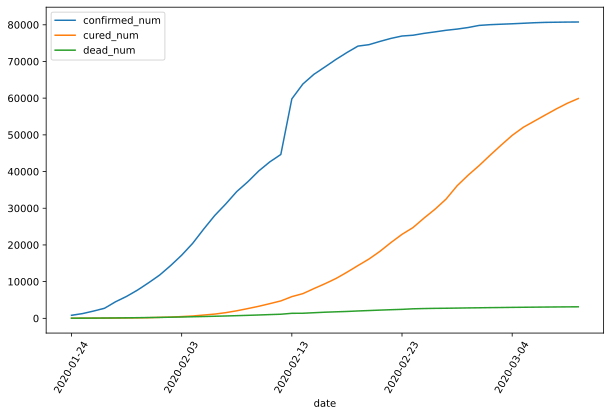

time: 652 ms (started: 2021-08-13 14:32:47 +08:00)


In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

df = pd.read_csv("./data/covid-19.csv",sep = "\t")
df.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)

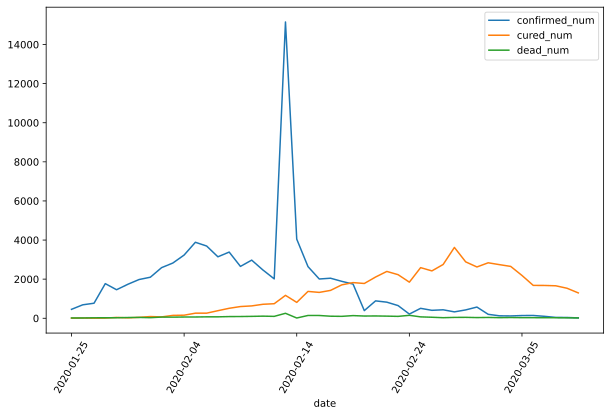

time: 208 ms (started: 2021-08-13 14:32:52 +08:00)


In [5]:
dfdata = df.set_index("date")
dfdiff = dfdata.diff(periods=1).dropna()
dfdiff = dfdiff.reset_index("date")

dfdiff.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)
dfdiff = dfdiff.drop("date",axis = 1).astype("float32")

In [6]:
#用某日前8天窗口数据作为输入预测该日数据
WINDOW_SIZE = 8

def batch_dataset(dataset):
    dataset_batched = dataset.batch(WINDOW_SIZE,drop_remainder=True)
    return dataset_batched

ds_data = tf.data.Dataset.from_tensor_slices(tf.constant(dfdiff.values,dtype = tf.float32)) \
   .window(WINDOW_SIZE,shift=1).flat_map(batch_dataset)

ds_label = tf.data.Dataset.from_tensor_slices(
    tf.constant(dfdiff.values[WINDOW_SIZE:],dtype = tf.float32))

#数据较小，可以将全部训练数据放入到一个batch中，提升性能
ds_train = tf.data.Dataset.zip((ds_data,ds_label)).batch(38).cache()

time: 1.46 s (started: 2021-08-13 14:32:54 +08:00)


### 二，定义模型

使用Keras接口有以下3种方式构建模型：使用Sequential按层顺序构建模型，使用函数式API构建任意结构模型，继承Model基类构建自定义模型。

此处选择使用函数式API构建任意结构模型。

In [7]:
#考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
class Block(layers.Layer):
    def __init__(self, **kwargs):
        super(Block, self).__init__(**kwargs)
    
    def call(self, x_input,x):
        x_out = tf.maximum((1+x)*x_input[:,-1,:],0.0)
        return x_out
    
    def get_config(self):  
        config = super(Block, self).get_config()
        return config

time: 1.92 ms (started: 2021-08-13 14:32:58 +08:00)


In [8]:
tf.keras.backend.clear_session()
x_input = layers.Input(shape = (None,3),dtype = tf.float32)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x_input)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,input_shape=(None,3))(x)
x = layers.Dense(3)(x)

#考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
#x = tf.maximum((1+x)*x_input[:,-1,:],0.0)
x = Block()(x_input,x)
model = models.Model(inputs = [x_input],outputs = [x])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 3)      84          input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, None, 3)      84          lstm[0][0]                       
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, None, 3)      84          lstm_1[0][0]                     
______________________________________________________________________________________________

### 三，训练模型

训练模型通常有3种方法，内置fit方法，内置train_on_batch方法，以及自定义训练循环。此处我们选择最常用也最简单的内置fit方法。

注：循环神经网络调试较为困难，需要设置多个不同的学习率多次尝试，以取得较好的效果。

In [11]:
#自定义损失函数，考虑平方差和预测目标的比值
class MSPE(losses.Loss):
    def call(self,y_true,y_pred):
        err_percent = (y_true - y_pred)**2/(tf.maximum(y_true**2,1e-7))
        mean_err_percent = tf.reduce_mean(err_percent)
        return mean_err_percent
    
    def get_config(self):
        config = super(MSPE, self).get_config()
        return config

time: 626 µs (started: 2021-08-13 14:33:27 +08:00)


In [12]:
import os
import datetime

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join('data', 'autograph', stamp)

## 在 Python3 下建议使用 pathlib 修正各操作系统的路径
# from pathlib import Path
# stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = str(Path('./data/autograph/' + stamp))

tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
#如果loss在100个epoch后没有提升，学习率减半。
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor = 0.5, patience = 100)
#当loss在200个epoch后没有提升，则提前终止训练。
stop_callback = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience= 200)
callbacks_list = [tb_callback,lr_callback,stop_callback]

history = model.fit(ds_train,epochs=500,callbacks = callbacks_list)

Epoch 1/500
1/1 [==============================] - 4s 4s/step - loss: 0.2094
Epoch 2/500
1/1 [==============================] - 0s 164ms/step - loss: 0.6336
Epoch 3/500
1/1 [==============================] - 0s 17ms/step - loss: 0.2599
Epoch 4/500
1/1 [==============================] - 0s 15ms/step - loss: 0.2175
Epoch 5/500
1/1 [==============================] - 0s 15ms/step - loss: 0.2200
Epoch 6/500
1/1 [==============================] - 0s 15ms/step - loss: 0.2257
Epoch 7/500
1/1 [==============================] - 0s 15ms/step - loss: 0.2334
Epoch 8/500
1/1 [==============================] - 0s 15ms/step - loss: 0.2403
Epoch 9/500
1/1 [==============================] - 0s 15ms/step - loss: 0.2449
Epoch 10/500
1/1 [==============================] - 0s 15ms/step - loss: 0.2476
Epoch 11/500
1/1 [==============================] - 0s 15ms/step - loss: 0.2492
Epoch 12/500
1/1 [==============================] - 0s 15ms/step - loss: 0.2504
Epoch 13/500
1/1 [==============================] 

### 四，评估模型

评估模型一般要设置验证集或者测试集，由于此例数据较少，我们仅仅可视化损失函数在训练集上的迭代情况。

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.title('Training '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric])
    plt.show()

time: 21.1 ms (started: 2021-08-13 14:33:56 +08:00)


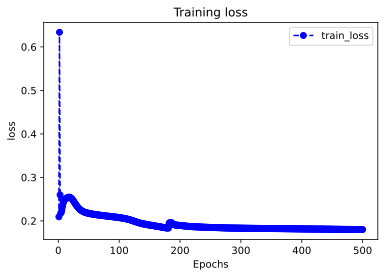

time: 203 ms (started: 2021-08-13 14:33:57 +08:00)


In [14]:
plot_metric(history,"loss")

### 五，使用模型

此处我们使用模型预测疫情结束时间，即 新增确诊病例为0 的时间。

In [15]:
#使用dfresult记录现有数据以及此后预测的疫情数据
dfresult = dfdiff[["confirmed_num","cured_num","dead_num"]].copy()
dfresult.tail()

,confirmed_num,cured_num,dead_num
41,143.0,1681.0,30.0
42,99.0,1678.0,28.0
43,44.0,1661.0,27.0
44,40.0,1535.0,22.0
45,19.0,1297.0,17.0


time: 22.1 ms (started: 2021-08-13 14:34:07 +08:00)


![](./data/1-4-日期3月10.png)

In [16]:
#预测此后100天的新增走势,将其结果添加到dfresult中
for i in range(100):
    arr_predict = model.predict(tf.constant(tf.expand_dims(dfresult.values[-38:,:],axis = 0)))

    dfpredict = pd.DataFrame(tf.cast(tf.floor(arr_predict),tf.float32).numpy(),
                columns = dfresult.columns)
    dfresult = dfresult.append(dfpredict,ignore_index=True)

time: 6.28 s (started: 2021-08-13 14:34:13 +08:00)


In [17]:
dfresult.query("confirmed_num==0").head()

# 第55天开始新增确诊降为0，第45天对应3月10日，也就是10天后，即预计3月20日新增确诊降为0
# 注：该预测偏乐观

,confirmed_num,cured_num,dead_num
54,0.0,2890.0,4.0
55,0.0,2265.0,3.0
56,0.0,1775.0,2.0
57,0.0,2023.0,1.0
58,0.0,2306.0,0.0


time: 11.4 ms (started: 2021-08-13 14:34:20 +08:00)


In [18]:
dfresult.query("cured_num==0").head()

# 第164天开始新增治愈降为0，第45天对应3月10日，也就是大概4个月后，即7月10日左右全部治愈。
# 注: 该预测偏悲观，并且存在问题，如果将每天新增治愈人数加起来，将超过累计确诊人数。

,confirmed_num,cured_num,dead_num
90,0.0,0.0,0.0
91,0.0,0.0,0.0
92,0.0,0.0,0.0
93,0.0,0.0,0.0
94,0.0,0.0,0.0


time: 14.6 ms (started: 2021-08-13 14:34:36 +08:00)


In [19]:
dfresult.query("dead_num==0").head()

# 第60天开始，新增死亡降为0，第45天对应3月10日，也就是大概15天后，即20200325
# 该预测较为合理

,confirmed_num,cured_num,dead_num
58,0.0,2306.0,0.0
59,0.0,1807.0,0.0
60,0.0,1416.0,0.0
61,0.0,1614.0,0.0
62,0.0,1840.0,0.0


time: 14.2 ms (started: 2021-08-13 14:34:40 +08:00)


### 六，保存模型

推荐使用TensorFlow原生方式保存模型。

In [20]:
model.save('./data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

INFO:tensorflow:Assets written to: ./data/tf_model_savedmodel/assets


INFO:tensorflow:Assets written to: ./data/tf_model_savedmodel/assets


export saved model.
time: 9.73 s (started: 2021-08-13 14:34:48 +08:00)


In [21]:
model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel',compile=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_loaded.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))
model_loaded.predict(ds_train)

array([[2033.5267  ,   98.37117 ,    0.      ],
       [2508.2424  ,   77.13194 ,    0.      ],
       [2736.8809  ,  164.32457 ,    0.      ],
       [3132.1543  ,  175.50311 ,    0.      ],
       [3764.7856  ,  290.6421  ,    0.      ],
       [3578.7744  ,  291.75995 ,    0.      ],
       [3044.9617  ,  432.6096  ,    0.      ],
       [3279.413   ,  570.10565 ,    0.      ],
       [2569.2773  ,  669.59467 ,    0.      ],
       [2880.2644  ,  706.4839  ,    0.      ],
       [2390.0479  ,  799.2658  ,    0.      ],
       [1396.1034  ,  747.3787  ,    0.      ],
       [4107.6274  ,  999.29626 ,    0.      ],
       [2283.637   ,  826.8635  ,    7.131122],
       [2283.867   , 1559.1935  ,  118.73429 ],
       [2072.4612  , 1542.561   ,  131.0329  ],
       [2192.0603  , 1626.8318  ,   98.31307 ],
       [1367.2003  , 1652.887   ,  108.501434],
       [ 387.96588 , 1549.6931  ,  129.08328 ],
       [ 433.51263 , 2049.357   ,  100.3678  ],
       [ 957.84247 , 2371.4585  ,   94.5

time: 6.1 s (started: 2021-08-13 14:34:58 +08:00)


如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"Python与算法之美"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![image.png](./data/Python与算法之美logo.jpg)